Total frames: 322
Usable right heel frames: 322
Y-change threshold (filtering top 25%): 0.1022
Y-change range: 0.0061 to 0.1105
Kept minimum at frame 4: Y=0.752, change=0.0663
Kept minimum at frame 39: Y=0.826, change=0.0184
Filtered by distance: frame 46
Kept minimum at frame 80: Y=0.747, change=0.1012
Kept minimum at frame 122: Y=0.827, change=0.0356
Filtered by Y-change: frame 157: Y=0.753, change=0.1056
Kept minimum at frame 186: Y=0.859, change=0.0061
Kept minimum at frame 200: Y=0.842, change=0.0296
Filtered by Y-change: frame 234: Y=0.769, change=0.1105
Kept minimum at frame 275: Y=0.870, change=0.0174
Filtered by Y-change: frame 307: Y=0.774, change=0.1033

Found 7 Local Minima:
Minimum 1: Frame 4, Time 0.133s, Y = 0.75170
Minimum 2: Frame 39, Time 1.300s, Y = 0.82625
Minimum 3: Frame 80, Time 2.667s, Y = 0.74691
Minimum 4: Frame 122, Time 4.067s, Y = 0.82681
Minimum 5: Frame 186, Time 6.200s, Y = 0.85903
Minimum 6: Frame 200, Time 6.667s, Y = 0.84205
Minimum 7: Frame 275, Time

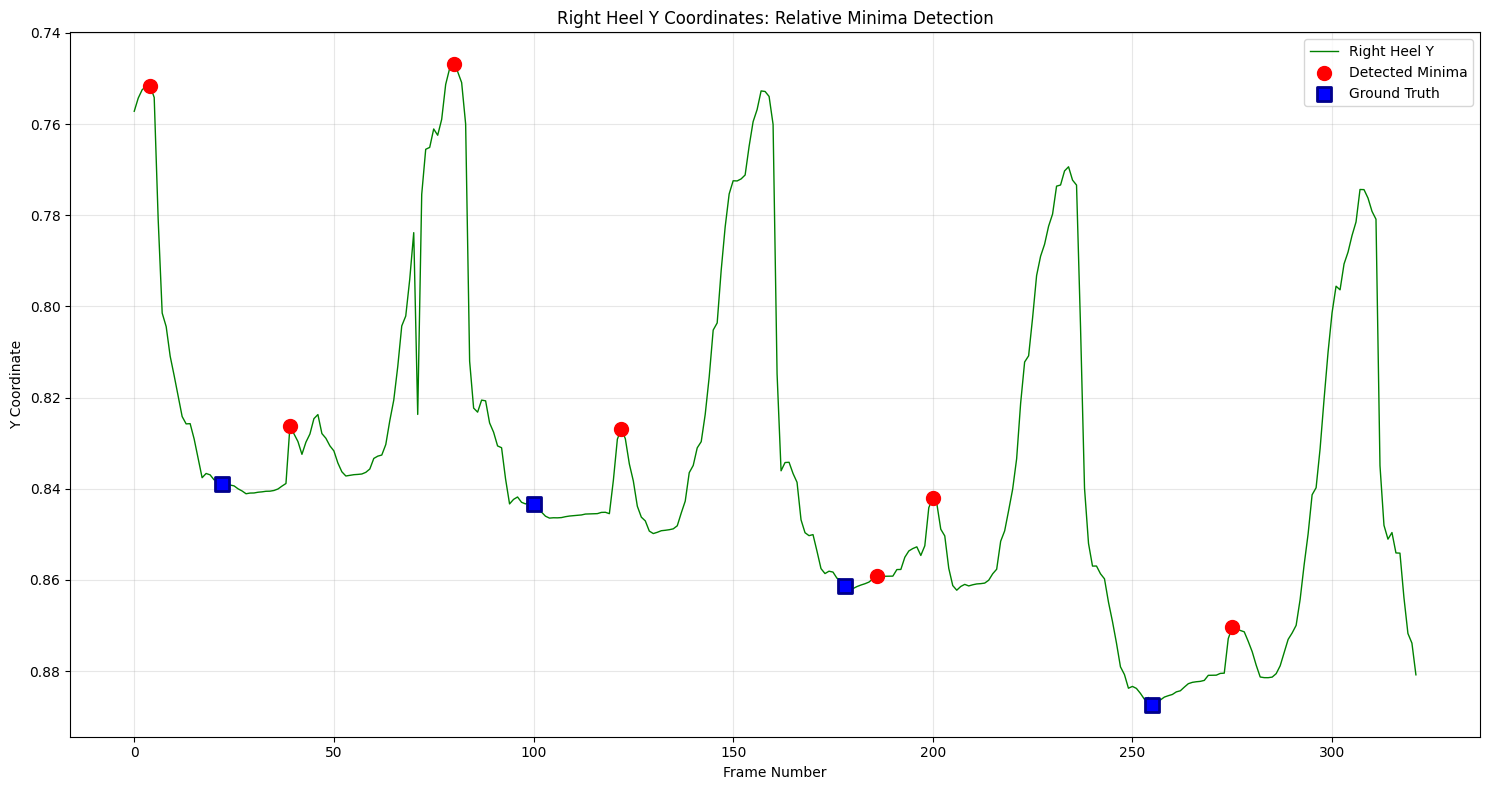

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Load the CSV from your heel detector
df = pd.read_csv('/Users/yejinbang/Documents/GitHub/sfx-project/data/walk4_frame_data_v1.csv')

# Load ground truth data
with open('/Users/yejinbang/Documents/GitHub/sfx-project/data/test_videos/walk4_ground_truth.json', 'r') as f:
    gt_data = json.load(f)

# Filter out frames where right heel is not usable (low confidence)
df_filtered = df[df['right_heel_usable'] == True].copy()

print(f"Total frames: {len(df)}")
print(f"Usable right heel frames: {len(df_filtered)}")

def find_local_minima_relative(df_data, window_size=3, min_distance=10, jump_threshold_percentile=75):
    """
    Find local minima while filtering out swing phase peaks based on relative Y changes
    
    Parameters:
    - jump_threshold_percentile: Ignore minima with Y changes above this percentile (filters swing phases)
    """
    minima = []
    y_values = df_data['right_heel_y'].values
    frames = df_data['frame_number'].values
    timestamps = df_data['timestamp'].values
    
    n = len(y_values)
    
    # First pass: find all potential minima and their Y-change magnitudes
    potential_minima = []
    
    for i in range(window_size, n - window_size):
        current_val = y_values[i]
        
        # Check if it's a local minimum
        is_minimum = True
        for j in range(i - window_size, i + window_size + 1):
            if j != i and y_values[j] <= current_val:
                is_minimum = False
                break
        
        if is_minimum:
            # Calculate the Y-change magnitude around this minimum
            # Look at larger window to see how much Y changed to reach this point
            look_back = min(15, i)  # Look back up to 15 frames
            look_forward = min(15, n - i - 1)  # Look forward up to 15 frames
            
            if look_back > 0 and look_forward > 0:
                before_y = np.mean(y_values[i-look_back:i])
                after_y = np.mean(y_values[i+1:i+look_forward+1])
                
                # Calculate how much Y dropped to reach this minimum
                drop_magnitude = abs(before_y - current_val)
                rise_magnitude = abs(after_y - current_val)
                total_change = drop_magnitude + rise_magnitude
                
                potential_minima.append({
                    'index': i,
                    'frame_number': frames[i],
                    'timestamp': timestamps[i],
                    'y_value': current_val,
                    'y_change_magnitude': total_change
                })
    
    if not potential_minima:
        return []
    
    # Calculate threshold for Y-change magnitude
    y_changes = [m['y_change_magnitude'] for m in potential_minima]
    change_threshold = np.percentile(y_changes, jump_threshold_percentile)
    
    print(f"Y-change threshold (filtering top {100-jump_threshold_percentile}%): {change_threshold:.4f}")
    print(f"Y-change range: {np.min(y_changes):.4f} to {np.max(y_changes):.4f}")
    
    # Second pass: filter out minima with large Y changes (swing phases)
    for minimum in potential_minima:
        if minimum['y_change_magnitude'] <= change_threshold:
            # Apply minimum distance constraint
            if not minima or (minimum['index'] - minima[-1]['index']) >= min_distance:
                minima.append({
                    'index': minimum['index'],
                    'frame_number': minimum['frame_number'],
                    'timestamp': minimum['timestamp'],
                    'y_value': minimum['y_value']
                })
                print(f"Kept minimum at frame {minimum['frame_number']}: Y={minimum['y_value']:.3f}, change={minimum['y_change_magnitude']:.4f}")
            else:
                print(f"Filtered by distance: frame {minimum['frame_number']}")
        else:
            print(f"Filtered by Y-change: frame {minimum['frame_number']}: Y={minimum['y_value']:.3f}, change={minimum['y_change_magnitude']:.4f}")
    
    return minima

# Add this after your function definition:

# Find local minima using relative approach
minima = find_local_minima_relative(df_filtered, window_size=3, min_distance=10, jump_threshold_percentile=75)

print(f"\nFound {len(minima)} Local Minima:")
for i, minimum in enumerate(minima):
    print(f"Minimum {i+1}: Frame {minimum['frame_number']}, "
          f"Time {minimum['timestamp']:.3f}s, Y = {minimum['y_value']:.5f}")

# Extract ground truth right foot steps  
gt_right_steps = [step for step in gt_data['annotations'] if step['foot'] == 'right']
print(f"\nGround truth right foot steps: {len(gt_right_steps)}")

# Get Y coordinates for ground truth frames
gt_frames = []
gt_y_values = []
for gt_step in gt_right_steps:
    frame_num = gt_step['frame']
    matching_row = df_filtered[df_filtered['frame_number'] == frame_num]
    if not matching_row.empty:
        gt_frames.append(frame_num)
        gt_y_values.append(matching_row['right_heel_y'].iloc[0])

# Visualize results
plt.figure(figsize=(15, 8))
plt.plot(df_filtered['frame_number'], df_filtered['right_heel_y'], 'g-', linewidth=1, label='Right Heel Y')

# Mark detected minima (RED dots)
if minima:
    min_frames = [m['frame_number'] for m in minima]
    min_y_vals = [m['y_value'] for m in minima]
    plt.scatter(min_frames, min_y_vals, color='red', s=100, zorder=5, label='Detected Minima')

# Mark ground truth (BLUE dots)
if gt_frames:
    plt.scatter(gt_frames, gt_y_values, color='blue', s=100, marker='s', zorder=6, 
               label='Ground Truth', edgecolors='darkblue', linewidth=2)

plt.xlabel('Frame Number')
plt.ylabel('Y Coordinate')
plt.title('Right Heel Y Coordinates: Relative Minima Detection')
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()